In [1]:
#!/usr/bin/env python3
"""
Heart Disease Ordinal Regression Analysis - Complete Workflow
============================================================
Using Our bayes_ordinal Package
============================================================
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import scipy.stats as stats

# Import our bayes_ordinal package
import sys
sys.path.append('..')
import bayes_ordinal as bo

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("HEART DISEASE ORDINAL REGRESSION ANALYSIS - COMPLETE WORKFLOW")
print("=" * 70)
print("Using Our bayes_ordinal Package")
print("=" * 70)

HEART DISEASE ORDINAL REGRESSION ANALYSIS - COMPLETE WORKFLOW
Using Our bayes_ordinal Package


In [2]:
print("1. Loading and Cleaning Data...")
print("=" * 50)

# Load the heart disease dataset
data_path = Path("../Dataset/heart+disease")
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

data = pd.read_csv(data_path / "processed.cleveland.data", 
                 names=columns, na_values='?')
print(f"Raw dataset shape: {data.shape}")

# Clean the data
data_clean = data.copy()
data_clean = data_clean.fillna(data_clean.median())
print(f"Cleaned dataset shape: {data_clean.shape}")

# Check response variable
print(f"Response range: {data_clean['num'].min()} to {data_clean['num'].max()}")
print(f"Number of categories: {data_clean['num'].nunique()}")
print(f"Features: {columns[:-1]}")

# Display response distribution
print("\nResponse distribution:")
print(data_clean['num'].value_counts().sort_index())

# Prepare features
feature_cols = columns[:-1]  # All except 'num'
X = data_clean[feature_cols].values
y = data_clean['num'].values

# Ensure target starts from 0
if y.min() > 0:
    y = y - y.min()
print(f"Target adjusted to start from 0: {y.min()} to {y.max()}")

1. Loading and Cleaning Data...
Raw dataset shape: (303, 14)
Cleaned dataset shape: (303, 14)
Response range: 0 to 4
Number of categories: 5
Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Response distribution:
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
Target adjusted to start from 0: 0 to 4


In [3]:
print("\n2. Data Validation and Preprocessing...")
print("=" * 50)

# Validate data using our package
validation_results = bo.validate_ordinal_data(y, X)
print("Data validation completed")

# Standardize numerical features
X_standardized, scaler = bo.standardize_features(X)
print("Features standardized")

# Encode categorical features
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
X_encoded, encoders = bo.encode_categorical_features(X_standardized, categorical_cols)
print("Categorical features encoded")

print(f"Final data shape: X={X_encoded.shape}, y={y.shape}")
print(f"Number of ordinal categories: {len(np.unique(y))}")


2. Data Validation and Preprocessing...
Data validation completed
Features standardized
Categorical features encoded
Final data shape: X=(303, 13), y=(303,)
Number of ordinal categories: 5


In [4]:
print("\n3. Data Exploration and Analysis...")
print("=" * 50)

# Feature summary
print("Feature Summary:")
for i, col in enumerate(feature_cols):
    print(f"  {col}: mean={X_encoded[:, i].mean():.3f}, std={X_encoded[:, i].std():.3f}")

# Target distribution analysis for informed priors
print(f"\nTarget Distribution Analysis for Informed Priors:")
target_counts = np.bincount(y)
target_props = target_counts / len(y)
cumulative_props = np.cumsum(target_props)

print("Target distribution:")
for i, (count, prop, cum_prop) in enumerate(zip(target_counts, target_props, cumulative_props)):
    print(f"  Class {i}: {count} ({prop:.3f}) - Cumulative: {cum_prop:.3f}")

# Calculate informed cutpoint priors based on data
z_scores = stats.norm.ppf(cumulative_props[:-1])  # Exclude last (always 1.0)
print(f"\nInformed cutpoint priors (z-scores): {z_scores}")

# Correlation analysis
print(f"\nFeature Correlations with Target:")
for i, feature in enumerate(feature_cols):
    corr = np.corrcoef(X_encoded[:, i], y)[0, 1]
    print(f"  {feature}: {corr:.3f}")


3. Data Exploration and Analysis...
Feature Summary:
  age: mean=-0.000, std=1.000
  sex: mean=-0.000, std=1.000
  cp: mean=-0.000, std=1.000
  trestbps: mean=0.000, std=1.000
  chol: mean=0.000, std=1.000
  fbs: mean=-0.000, std=1.000
  restecg: mean=-0.000, std=1.000
  thalach: mean=-0.000, std=1.000
  exang: mean=-0.000, std=1.000
  oldpeak: mean=0.000, std=1.000
  slope: mean=0.000, std=1.000
  ca: mean=-0.000, std=1.000
  thal: mean=0.000, std=1.000

Target Distribution Analysis for Informed Priors:
Target distribution:
  Class 0: 164 (0.541) - Cumulative: 0.541
  Class 1: 55 (0.182) - Cumulative: 0.723
  Class 2: 36 (0.119) - Cumulative: 0.842
  Class 3: 35 (0.116) - Cumulative: 0.957
  Class 4: 13 (0.043) - Cumulative: 1.000

Informed cutpoint priors (z-scores): [0.10359375 0.59109698 1.00098992 1.7179344 ]

Feature Correlations with Target:
  age: 0.223
  sex: 0.224
  cp: 0.407
  trestbps: 0.158
  chol: 0.071
  fbs: 0.059
  restecg: 0.184
  thalach: -0.415
  exang: 0.397
  old

In [5]:
print("\n4. Prior Specification...")
print("=" * 50)

# Define informed priors for the cumulative model
priors = {
    "beta": [0, 0.5],       # [mu, sigma] for beta - tighter priors
    "sigma": 0.5,           # Smaller sigma for stability
    "mu": z_scores,         # Data-informed cutpoint means
    "constrained_uniform": False
}

print("Prior specifications (informed by data):")
print(f"  beta: {priors['beta']} (coefficient mean=0, std=0.5)")
print(f"  sigma: {priors['sigma']} (cutpoint prior std=0.5)")
print(f"  mu: {priors['mu']} (data-informed cutpoint means)")
print(f"  constrained_uniform: {priors['constrained_uniform']}")


4. Prior Specification...
Prior specifications (informed by data):
  beta: [0, 0.5] (coefficient mean=0, std=0.5)
  sigma: 0.5 (cutpoint prior std=0.5)
  mu: [0.10359375 0.59109698 1.00098992 1.7179344 ] (data-informed cutpoint means)
  constrained_uniform: False


In [6]:
print("\n5. Building Models...")
print("=" * 50)

K = len(np.unique(y))
print(f"Number of ordinal categories: {K}")

# Build logit model
print("Building logit model...")
logit_model = bo.cumulative_model(
    y=y,
    X=X_encoded,
    K=K,
    link="logit",
    priors=priors,
    model_name="heart_disease_logit",
    prior_type="exponential_sigma",
    feature_names=feature_cols
)
print("Logit model built successfully")

# Build probit model
print("Building probit model...")
probit_model = bo.cumulative_model(
    y=y,
    X=X_encoded,
    K=K,
    link="probit",
    priors=priors,
    model_name="heart_disease_probit",
    prior_type="exponential_sigma",
    feature_names=feature_cols
)
print("Probit model built successfully")




5. Building Models...
Number of ordinal categories: 5
Building logit model...
Logit model built successfully
Building probit model...
Probit model built successfully



Model Structure:
Model Structure (PyMC Graphviz):


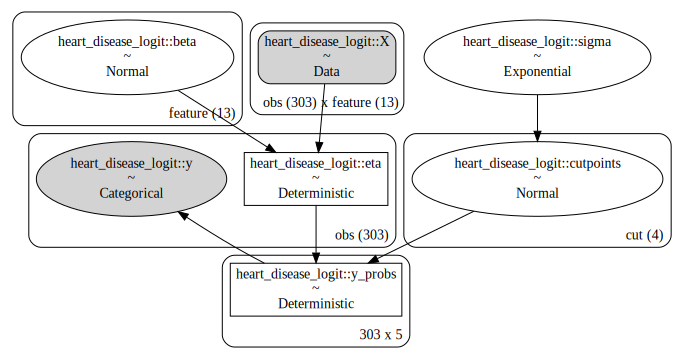

Logit model Graphviz visualization displayed successfully!


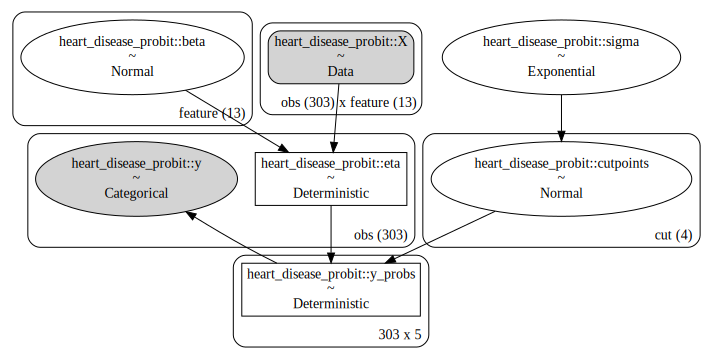

Probit model Graphviz visualization displayed successfully!


In [7]:
# Display model structure
print("\nModel Structure:")
print("Model Structure (PyMC Graphviz):")

model_graph_logit = pm.model_to_graphviz(logit_model)
display(model_graph_logit)
print("Logit model Graphviz visualization displayed successfully!")
model_graph_probit = pm.model_to_graphviz(probit_model)
display(model_graph_probit)
print("Probit model Graphviz visualization displayed successfully!")


6. Prior Predictive Checks...
Running prior predictive check for logit model...
 Running prior predictive check for model: heart_disease_logit
 Drawing 1000 samples from prior predictive distribution


Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]


 Successfully sampled 1000 prior predictive draws


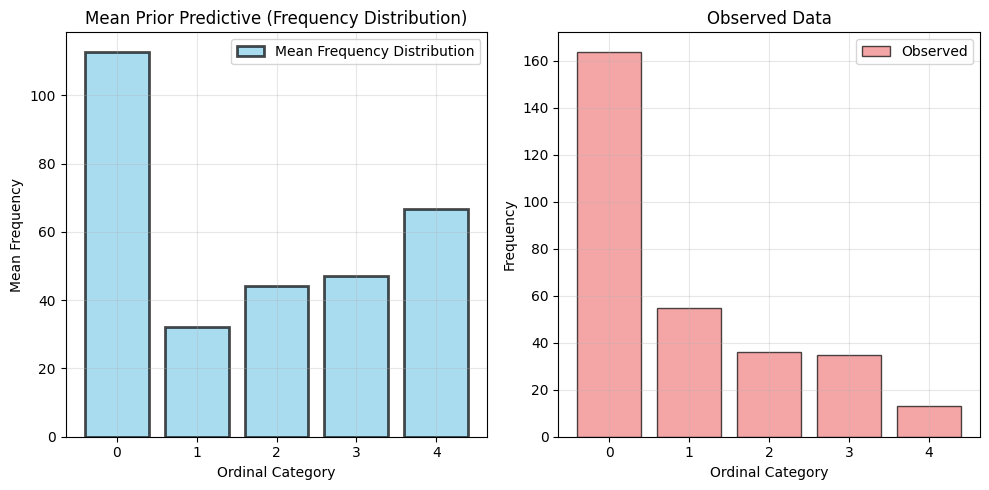

 Prior predictive plots generated successfully
 Prior predictive check completed successfully!
 Results stored in InferenceData object
Running prior predictive check for probit model...
 Running prior predictive check for model: heart_disease_probit
 Drawing 1000 samples from prior predictive distribution


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


 Successfully sampled 1000 prior predictive draws


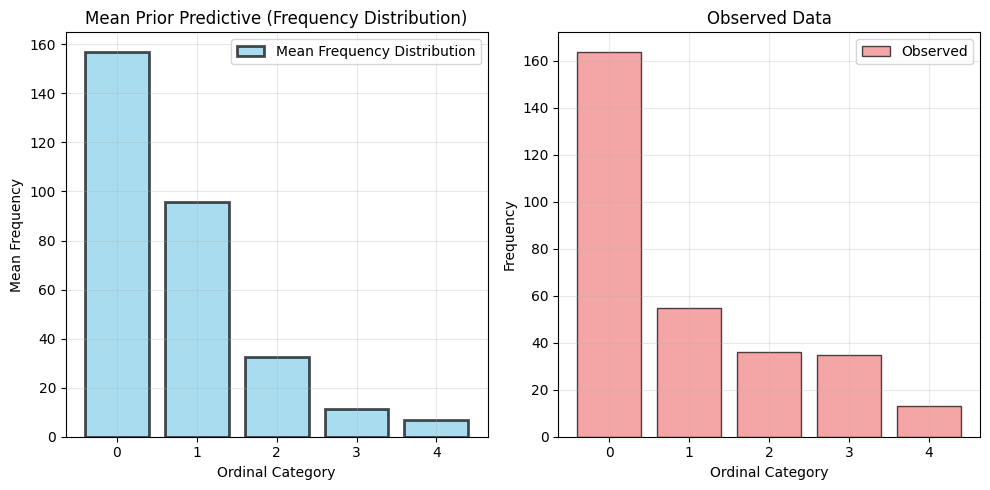

 Prior predictive plots generated successfully
 Prior predictive check completed successfully!
 Results stored in InferenceData object
Prior predictive checks completed for both models!


In [8]:
print("\n6. Prior Predictive Checks...")
print("=" * 50)

# Run prior predictive checks for logit model
print("Running prior predictive check for logit model...")
prior_pred_logit = bo.run_prior_predictive(
    model=logit_model,
    draws=1000,
    plot=True,
    y_obs=y,
    model_name="heart_disease_logit",
)

# Run prior predictive checks for probit model
print("Running prior predictive check for probit model...")
prior_pred_probit = bo.run_prior_predictive(
    model=probit_model,
    draws=1000,
    plot=True,
    y_obs=y,
    model_name="heart_disease_probit",
)

print("Prior predictive checks completed for both models!")

In [9]:
print("\n7. Model Fitting...")
print("=" * 50)

# Fit logit model with enhanced parameters
print("Fitting logit model...")
idata_logit = bo.fit_ordinal_model(
    model=logit_model,
    chains=4,
    draws=2000,
    tune=2000,  # More tuning for stability
    target_accept=0.95,  # Higher acceptance rate
    max_treedepth=20,    # More tree depth
    random_seed=42,
    init="adapt_diag",    # Better initialization
    enable_log_likelihood=True,        
    enable_posterior_predictive=True  
)
print("Logit model fitting completed")
print(f"InferenceData shape: {idata_logit.posterior['heart_disease_logit::beta'].shape}")

# Fit probit model with enhanced parameters
print("Fitting probit model...")
idata_probit = bo.fit_ordinal_model(
    model=probit_model,
    chains=4,
    draws=2000,
    tune=2000,
    target_accept=0.95,
    max_treedepth=20,
    random_seed=42,
    init="adapt_diag",
    enable_log_likelihood=True,       
    enable_posterior_predictive=True  
)
print("Probit model fitting completed")
print(f"InferenceData shape: {idata_probit.posterior['heart_disease_probit::beta'].shape}")


7. Model Fitting...
Fitting logit model...


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [heart_disease_logit::beta, heart_disease_logit::sigma, heart_disease_logit::cutpoints]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


Logit model fitting completed
InferenceData shape: (4, 2000, 13)
Fitting probit model...


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [heart_disease_probit::beta, heart_disease_probit::sigma, heart_disease_probit::cutpoints]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.


Probit model fitting completed
InferenceData shape: (4, 2000, 13)



8. Computational Validation and Model Verification...

1. Computational Issues Diagnosis:
 Diagnosing computational issues...
   R-hat: 0 parameters with issues
   ESS: 0 parameters with low ESS
   Divergences: 0 (0.00%)
   Energy plot: Created successfully

 No issues detected - model looks good!
 Diagnosing computational issues...


Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]


   R-hat: 0 parameters with issues
   ESS: 0 parameters with low ESS
   Divergences: 0 (0.00%)
   Energy plot: Created successfully

 No issues detected - model looks good!

2. Multimodality Checks:
Logit model:
 Checking for multimodality...
  heart_disease_logit::beta:  Unimodal (1 peaks)
  heart_disease_logit::cutpoints:  MULTIMODAL (4 peaks)

  1 variables show multimodality

Probit model:
 Checking for multimodality...
  heart_disease_probit::beta:  Unimodal (0 peaks)
  heart_disease_probit::cutpoints:  MULTIMODAL (4 peaks)

  1 variables show multimodality

3. Fake Data Simulation Tests (Model Implementation Validation):
Testing logit model implementation...
 Running fake data simulation (10 simulations)...
   Simulation 1: Success
   Simulation 2: Success
   Simulation 3: Success
   Simulation 4: Success
   Simulation 5: Success
   Simulation 6: Success


Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]


   Simulation 7: Success
   Simulation 8: Success
   Simulation 9: Success


Sampling: [heart_disease_logit::beta, heart_disease_logit::cutpoints, heart_disease_logit::sigma, heart_disease_logit::y]
Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 10: Success

 Simulation Results:
  Total: 10
  Successful: 10
  Failed: 0
  Success Rate: 100.0%
 All simulations successful! Model implementation looks good.
Testing probit model implementation...
 Running fake data simulation (10 simulations)...
   Simulation 1: Success


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]
Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 2: Success
   Simulation 3: Success


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]
Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 4: Success
   Simulation 5: Success


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]
Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 6: Success
   Simulation 7: Success


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]
Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 8: Success
   Simulation 9: Success


Sampling: [heart_disease_probit::beta, heart_disease_probit::cutpoints, heart_disease_probit::sigma, heart_disease_probit::y]


   Simulation 10: Success

 Simulation Results:
  Total: 10
  Successful: 10
  Failed: 0
  Success Rate: 100.0%
 All simulations successful! Model implementation looks good.

 COMPUTATIONAL VALIDATION RESULTS:
Logit Model:
   Implementation test: 10/10 (100.0%)
Probit Model:
   Implementation test: 10/10 (100.0%)

 COMPUTATIONAL VALIDATION PASSED - Safe to proceed with analysis
 Computational validation completed


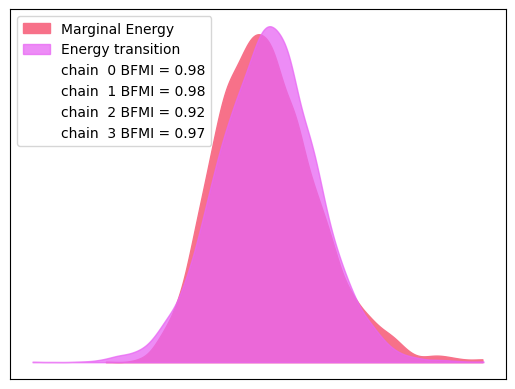

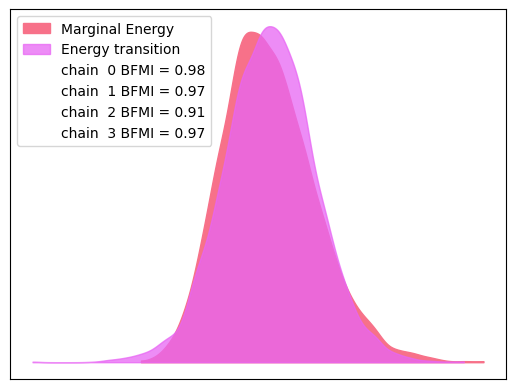

In [10]:
print("\n8. Computational Validation and Model Verification...")
print("=" * 60)

# Import computational validation functions
from bayes_ordinal.workflow.computation import (
    diagnose_computational_issues,
    check_multimodality,
    fake_data_simulation
)

# Diagnose computational issues
print("\n1. Computational Issues Diagnosis:")
logit_comp_issues = diagnose_computational_issues(idata_logit)
probit_comp_issues = diagnose_computational_issues(idata_probit)

# Check for multimodality
print("\n2. Multimodality Checks:")
print("Logit model:")
logit_multimodal = check_multimodality(
    idata_logit, 
    var_names=["heart_disease_logit::beta", "heart_disease_logit::cutpoints"]
)

print("\nProbit model:")
probit_multimodal = check_multimodality(
    idata_probit, 
    var_names=["heart_disease_probit::beta", "heart_disease_probit::cutpoints"]
)

# Fake data simulation tests (MOST IMPORTANT)
print("\n3. Fake Data Simulation Tests (Model Implementation Validation):")
print("Testing logit model implementation...")
logit_fake_data = fake_data_simulation(logit_model, n_simulations=10)

print("Testing probit model implementation...")
probit_fake_data = fake_data_simulation(probit_model, n_simulations=10)

print(f"\n COMPUTATIONAL VALIDATION RESULTS:")
print(f"Logit Model:")
print(f"   Implementation test: {logit_fake_data['n_successful']}/{logit_fake_data['n_simulations']} ({logit_fake_data['n_successful']/logit_fake_data['n_simulations']*100:.1f}%)")
print(f"Probit Model:")
print(f"   Implementation test: {probit_fake_data['n_successful']}/{probit_fake_data['n_simulations']} ({probit_fake_data['n_successful']/probit_fake_data['n_simulations']*100:.1f}%)")

# Determine if we can proceed
all_passed = (logit_fake_data['n_successful'] == logit_fake_data['n_simulations'] and 
              probit_fake_data['n_successful'] == probit_fake_data['n_simulations'])

if all_passed:
    print("\n COMPUTATIONAL VALIDATION PASSED - Safe to proceed with analysis")
else:
    print("\n  COMPUTATIONAL ISSUES DETECTED - Review model implementation")
    
print(" Computational validation completed")


9. Model Diagnostics...
Running comprehensive convergence diagnostics...
 Log likelihood available for LOO/WAIC calculations
  Max R-hat: 1.000
 Diagnostic summary completed
  Model: heart_disease_logit
  Summary shape: (1836, 12)
  R-hat column exists: True
  R-hat values: [1. 1. 1. ... 1. 1. 1.]
Creating diagnostic plots...
 Creating energy plot...


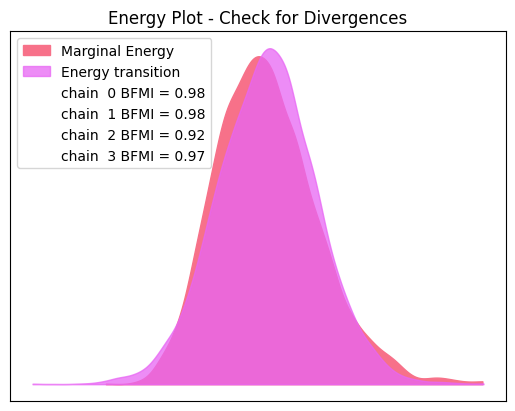

 Creating trace plots...


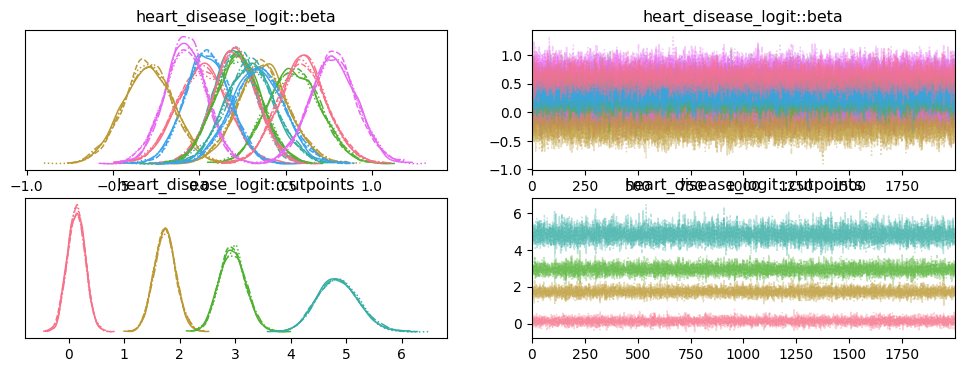

 Creating rank plots...


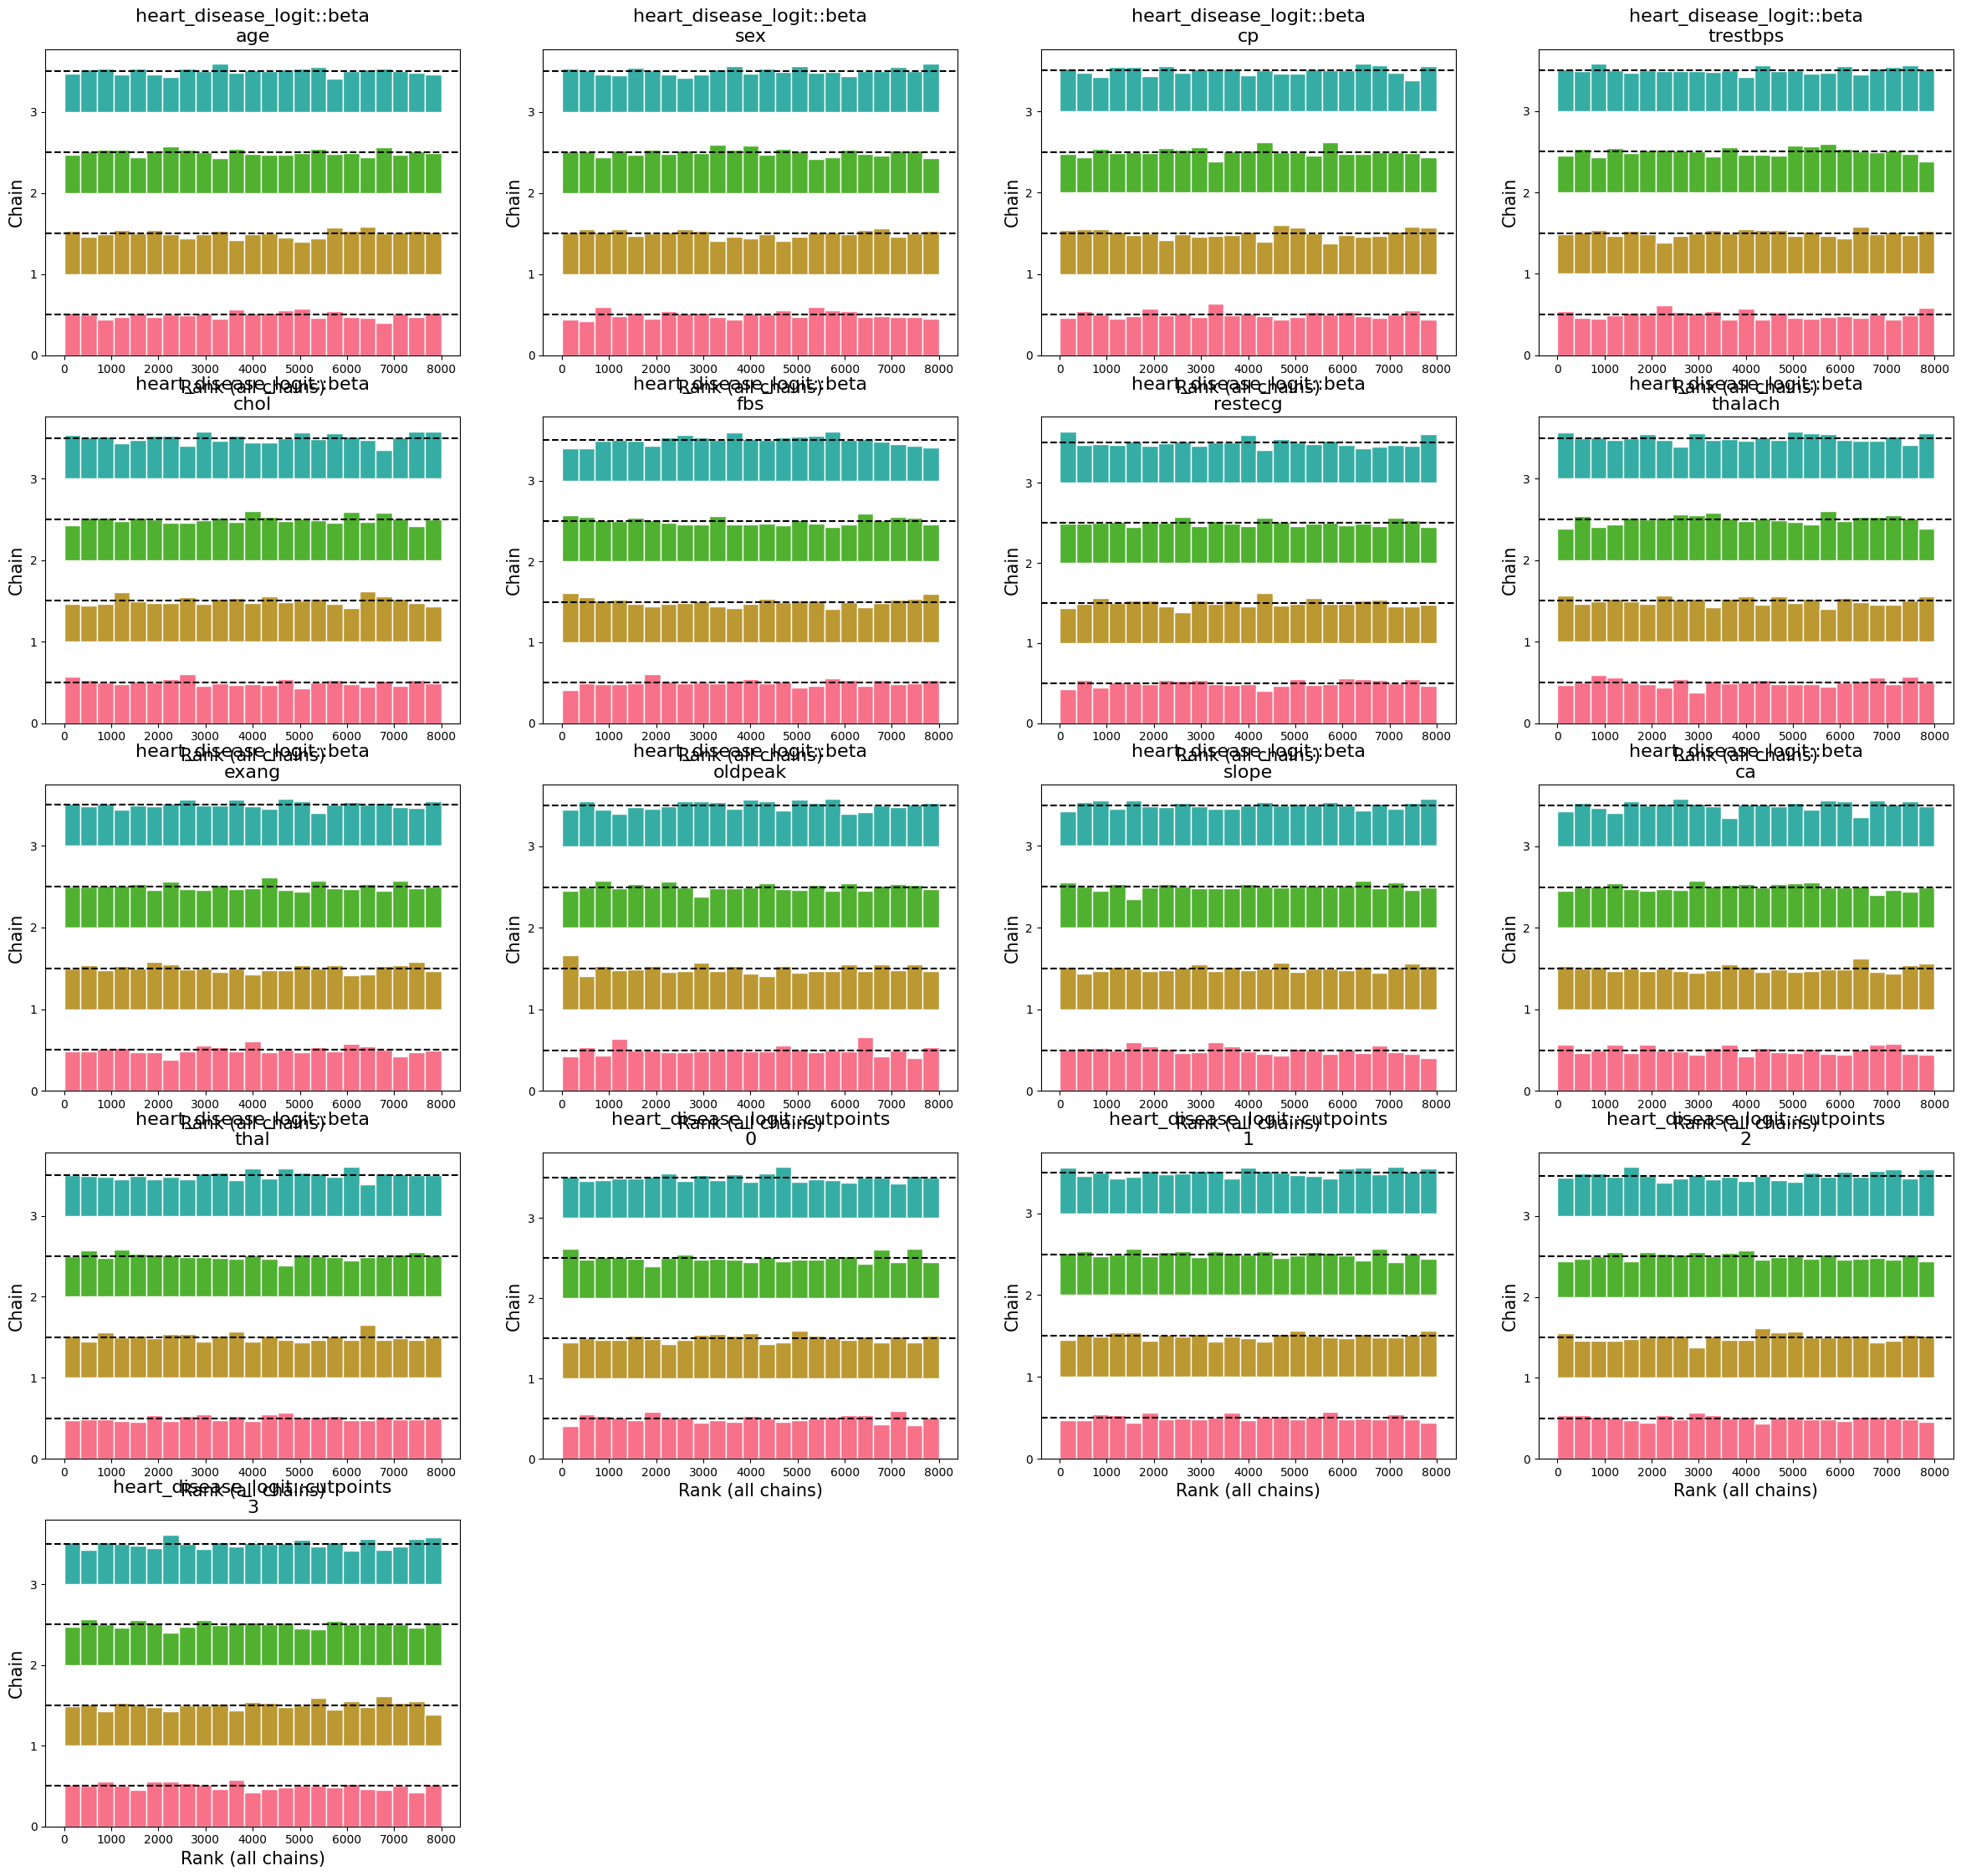

 Creating autocorrelation plots...


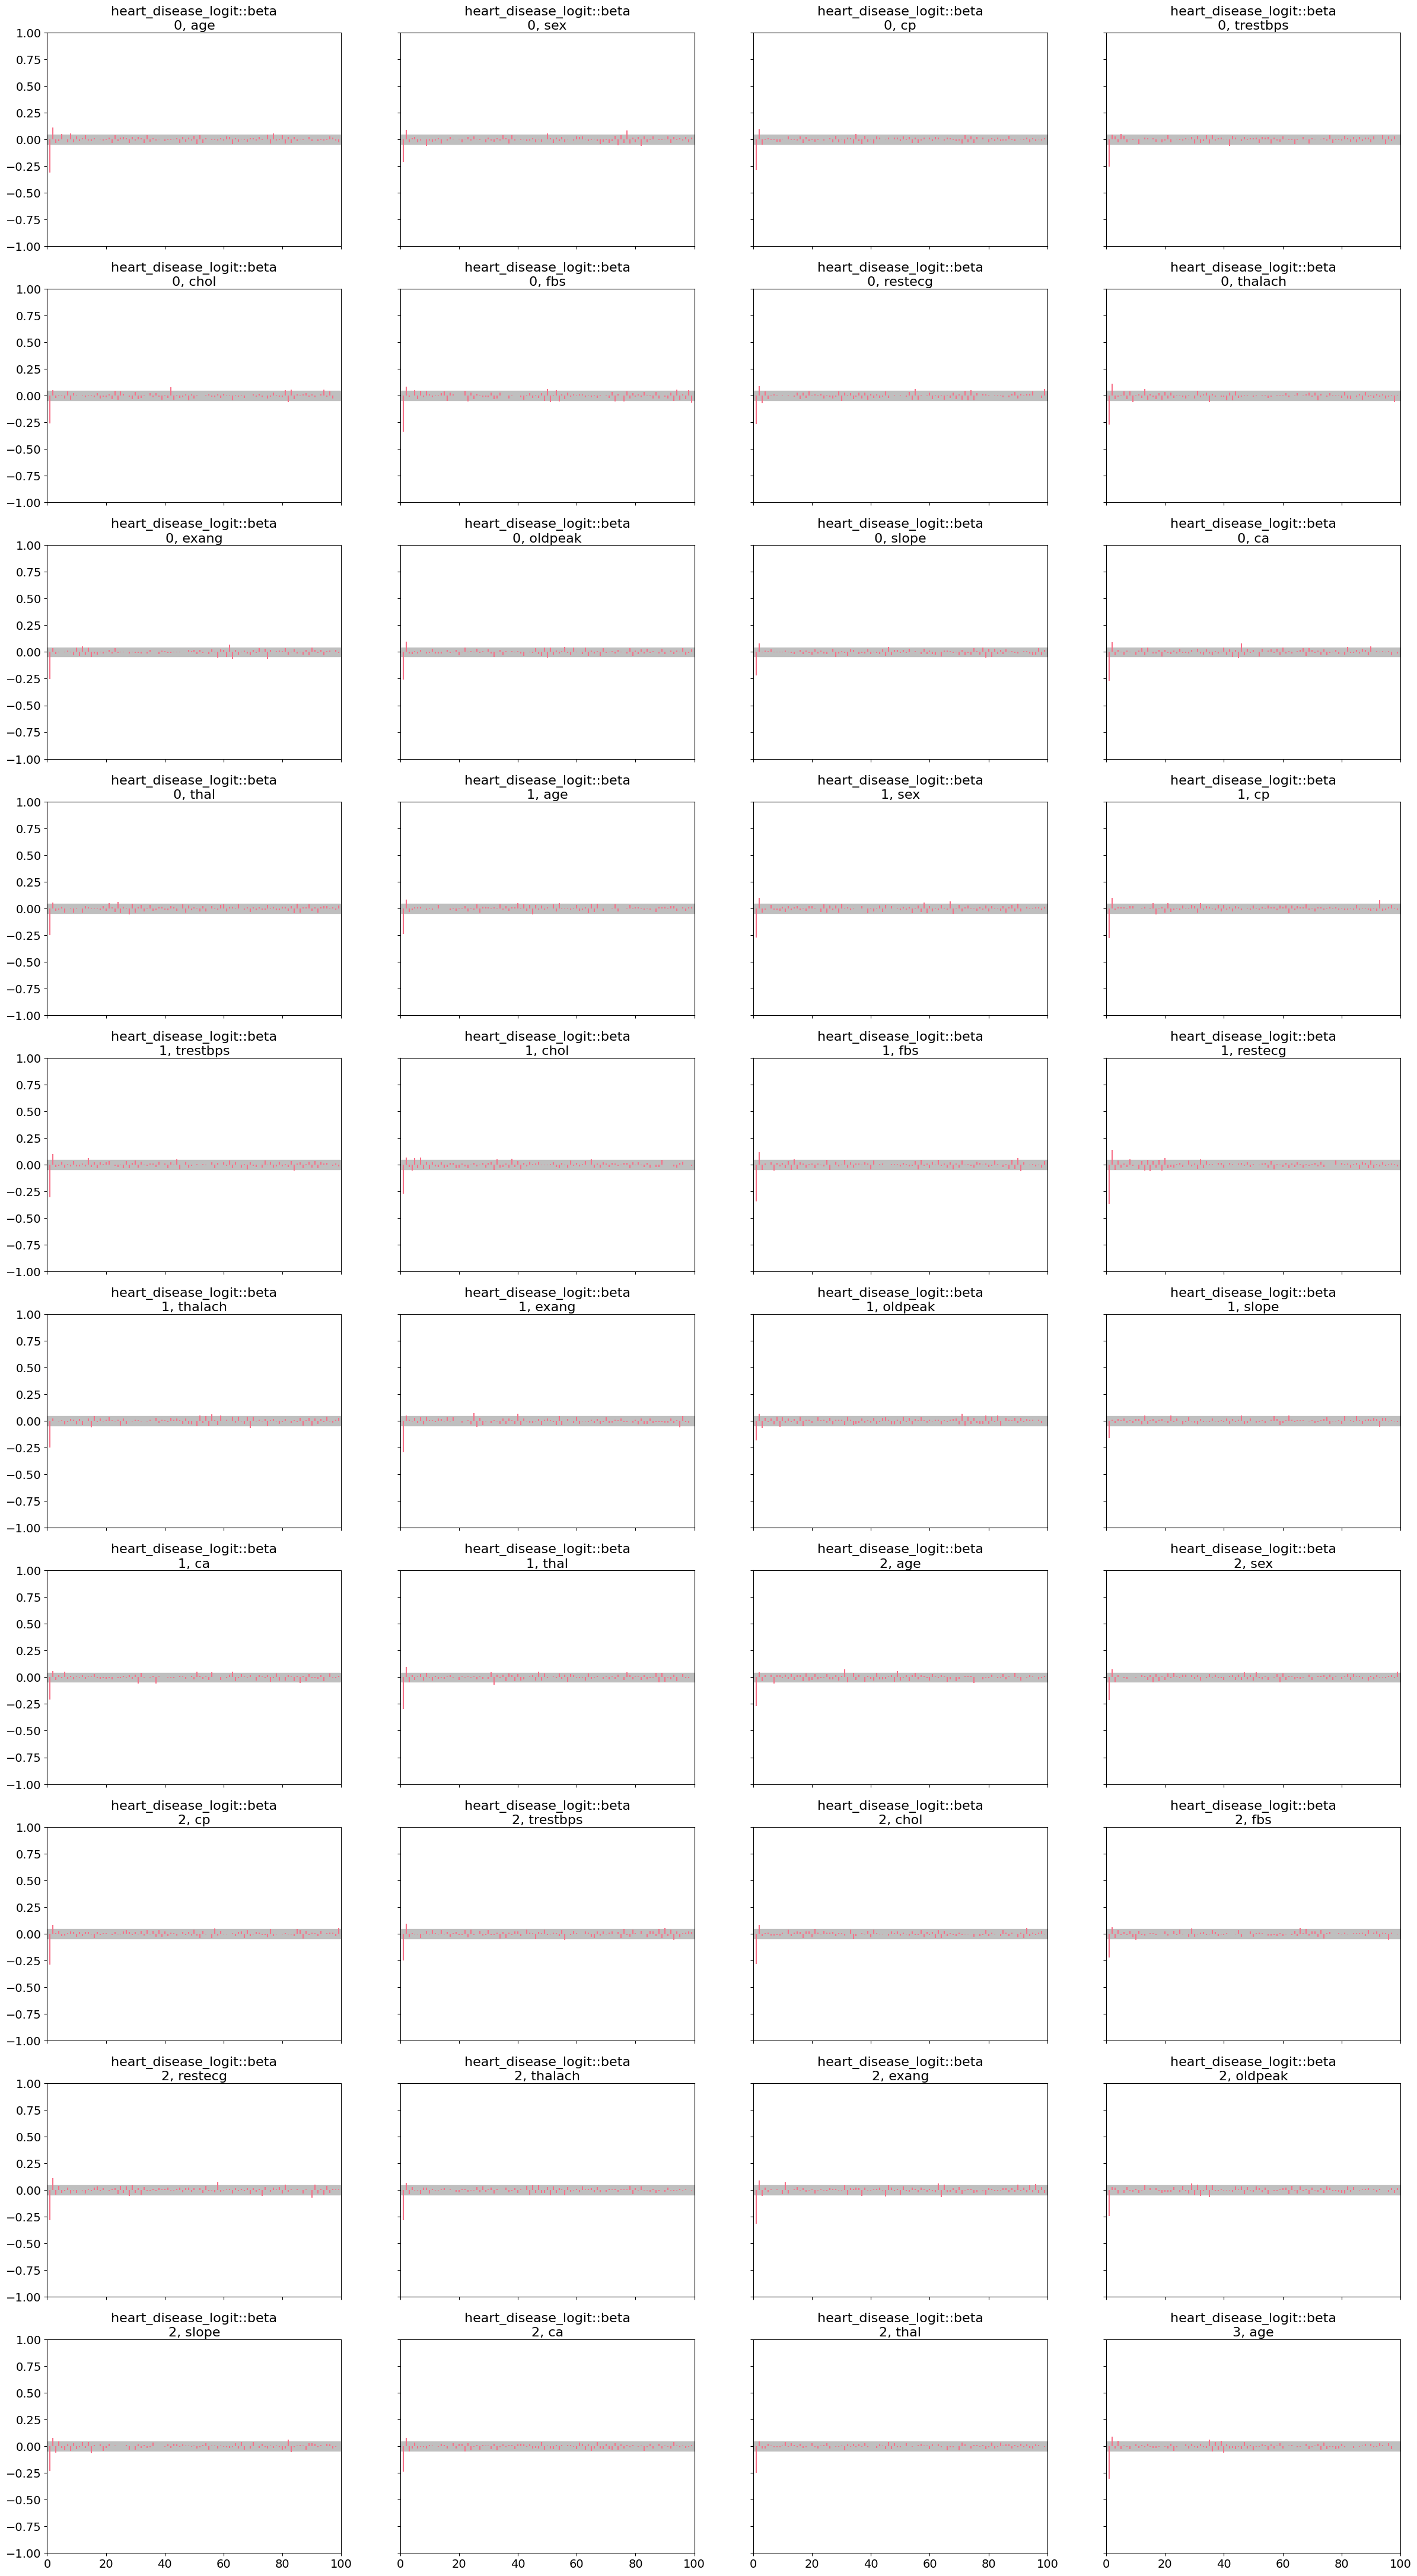

 Diagnostic plots completed
 Log likelihood available for LOO/WAIC calculations
  Max R-hat: 1.000
 Diagnostic summary completed
  Model: heart_disease_probit
  Summary shape: (1836, 12)
  R-hat column exists: True
  R-hat values: [1. 1. 1. ... 1. 1. 1.]
Creating diagnostic plots...
 Creating energy plot...


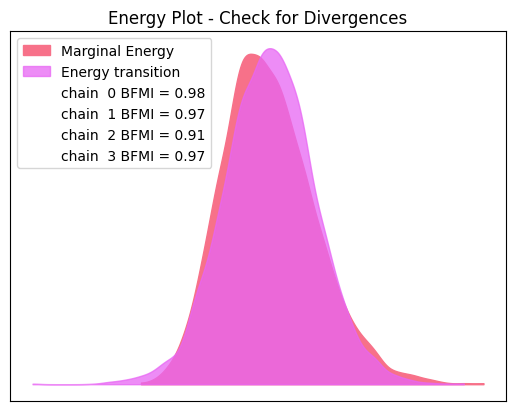

 Creating trace plots...


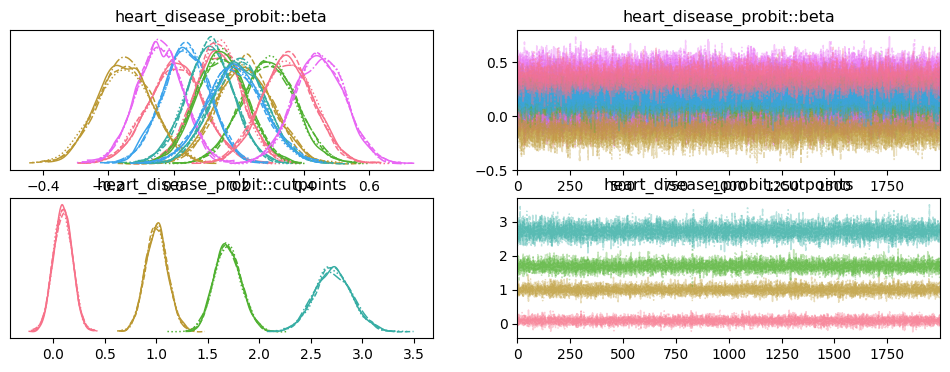

 Creating rank plots...


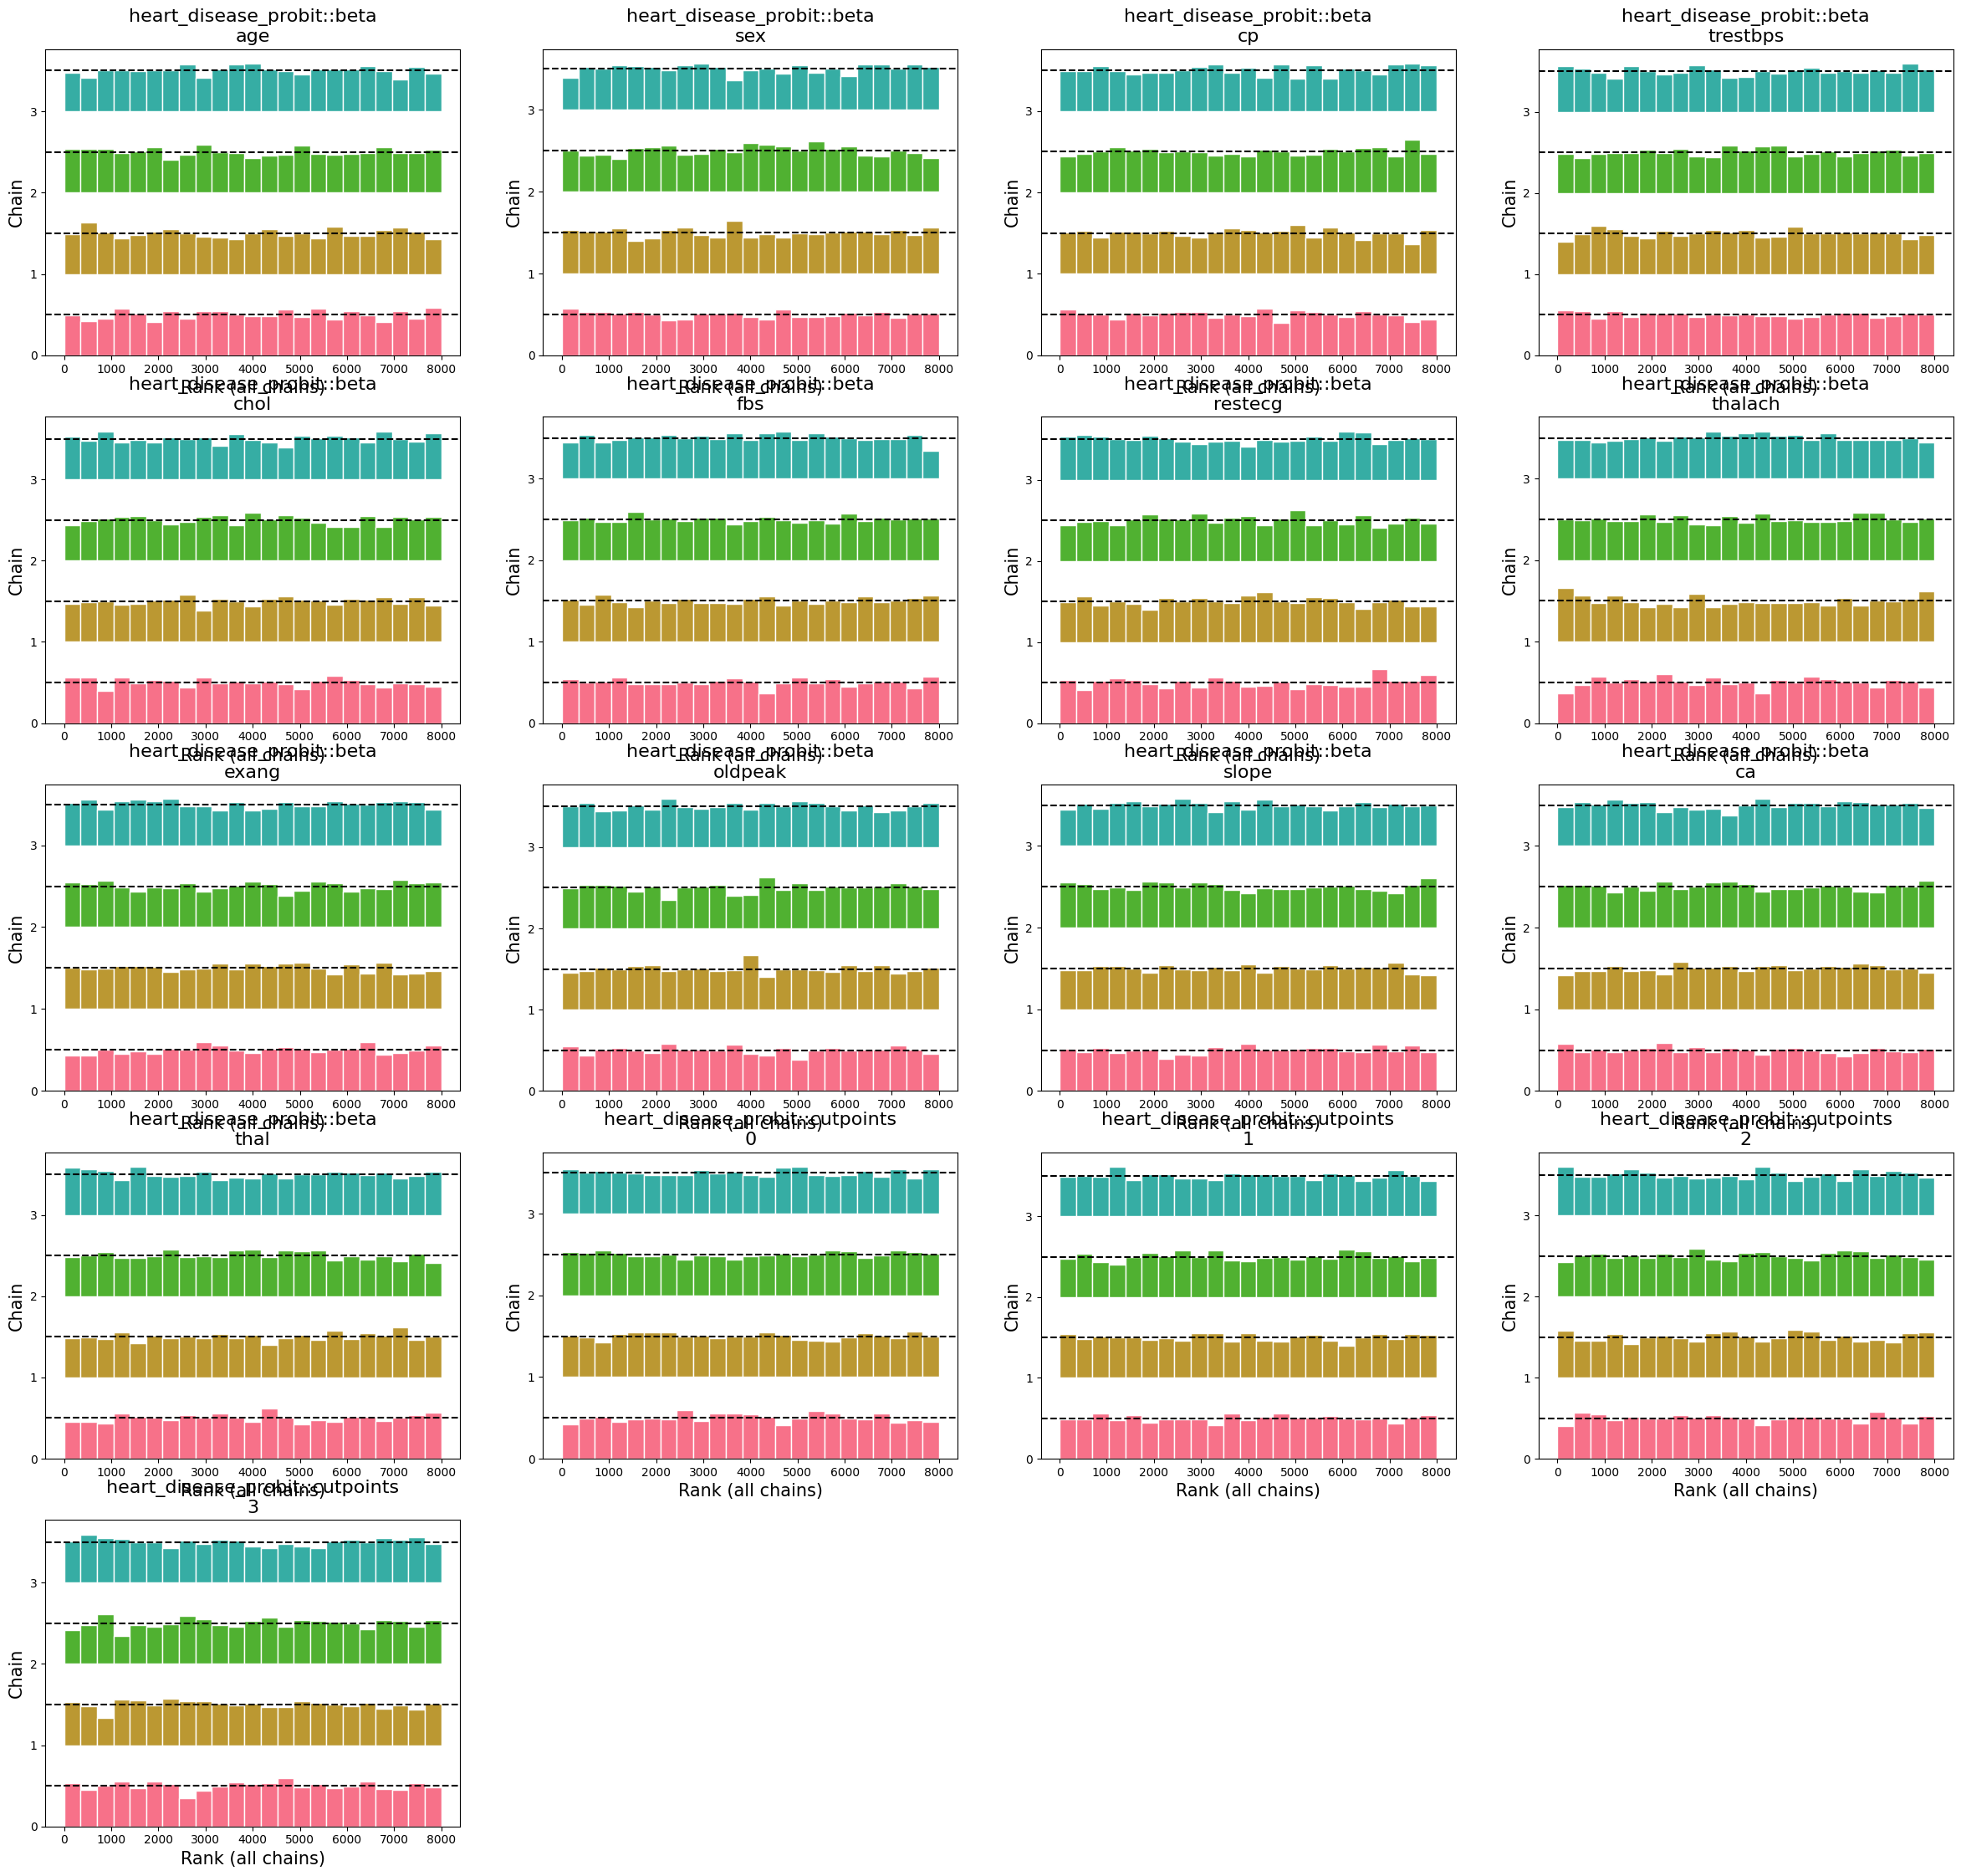

 Creating autocorrelation plots...


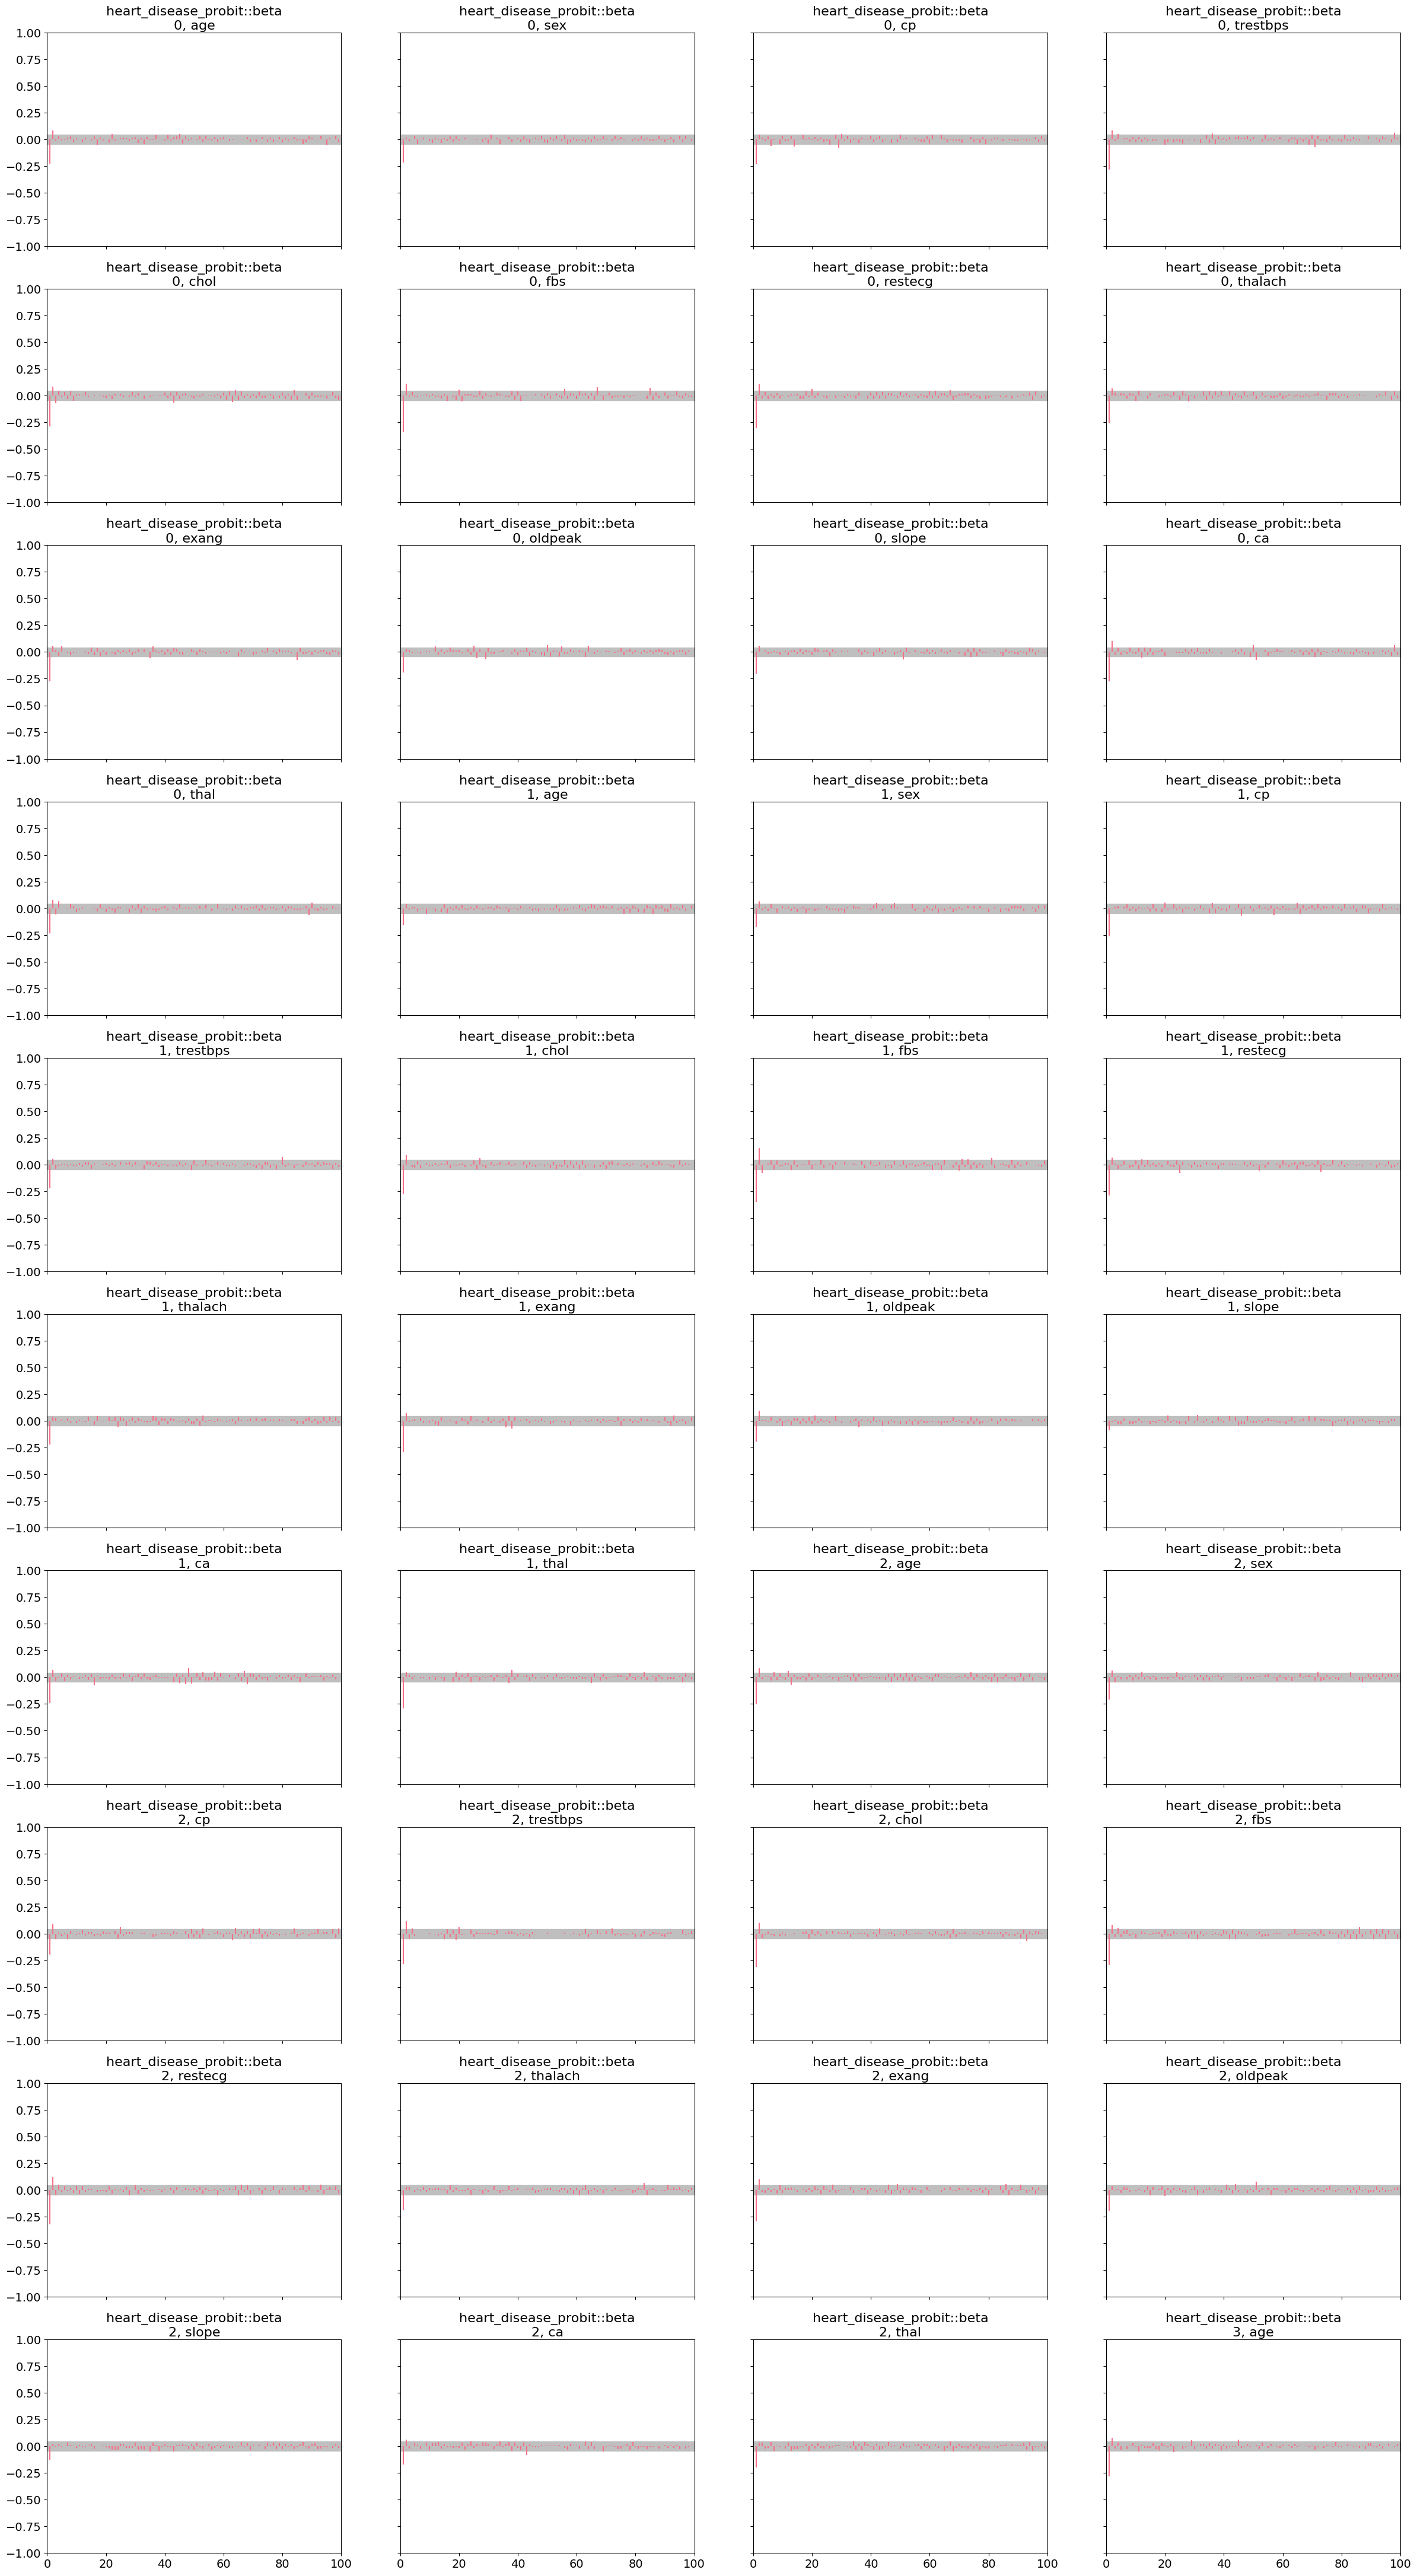

 Diagnostic plots completed

 Convergence Diagnostic Summary:
Logit Model:
   Max R-hat: 1.000
   Min ESS: 7667
   Divergences: 0
Probit Model:
   Max R-hat: 1.000
   Min ESS: 8760
   Divergences: 0

Parameter Summaries:

Logit Model Parameters:
                                      mean     sd  hdi_3%  hdi_97%   ess_bulk  \
heart_disease_logit::beta[age]       0.017  0.150  -0.275    0.281  14078.011   
heart_disease_logit::beta[sex]       0.368  0.150   0.079    0.646  12591.345   
heart_disease_logit::beta[cp]        0.548  0.153   0.257    0.825  13124.470   
heart_disease_logit::beta[trestbps]  0.209  0.128  -0.029    0.445  13189.862   
heart_disease_logit::beta[chol]      0.047  0.129  -0.199    0.281  14498.315   
heart_disease_logit::beta[fbs]      -0.081  0.122  -0.305    0.153  14799.757   
heart_disease_logit::beta[restecg]   0.207  0.128  -0.040    0.444  16083.850   
heart_disease_logit::beta[thalach]  -0.296  0.146  -0.563   -0.014  14620.821   
heart_disease_logit::beta

In [11]:
print("\n9. Model Diagnostics...")
print("=" * 50)

print("Running comprehensive convergence diagnostics...")

logit_diagnostics = bo.run_comprehensive_diagnostics(
    idata=idata_logit,
    model_name="heart_disease_logit",
    include_plots=True,
    include_summary=True
)

probit_diagnostics = bo.run_comprehensive_diagnostics(
    idata=idata_probit,
    model_name="heart_disease_probit",
    include_plots=True,
    include_summary=True
)

print(f"\n Convergence Diagnostic Summary:")
print(f"Logit Model:")
print(f"   Max R-hat: {logit_diagnostics.get('max_rhat', 'N/A'):.3f}")
print(f"   Min ESS: {logit_diagnostics.get('min_ess', 'N/A'):.0f}")
print(f"   Divergences: {logit_diagnostics.get('n_divergences', 0)}")

print(f"Probit Model:")
print(f"   Max R-hat: {probit_diagnostics.get('max_rhat', 'N/A'):.3f}")
print(f"   Min ESS: {probit_diagnostics.get('min_ess', 'N/A'):.0f}")
print(f"   Divergences: {probit_diagnostics.get('n_divergences', 0)}")

# Parameter summaries
print("\nParameter Summaries:")
print("===================")

print("\nLogit Model Parameters:")
logit_summary = az.summary(
    idata_logit, 
    var_names=["heart_disease_logit::beta", "heart_disease_logit::cutpoints"],
    round_to=3
)
print(logit_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

print("\nProbit Model Parameters:")
probit_summary = az.summary(
    idata_probit, 
    var_names=["heart_disease_probit::beta", "heart_disease_probit::cutpoints"],
    round_to=3
)
print(probit_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

print(" Model diagnostics completed successfully")

Sampling: [heart_disease_logit::y]



10. Posterior Predictive Checks...
Running posterior predictive checks for both models...

Logit Model - Histogram check:


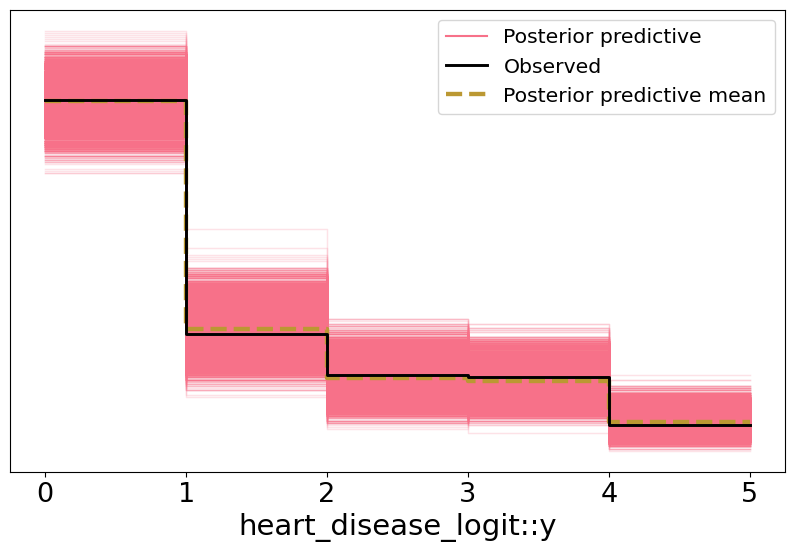

Sampling: [heart_disease_logit::y]



Logit Model - ECDF check:


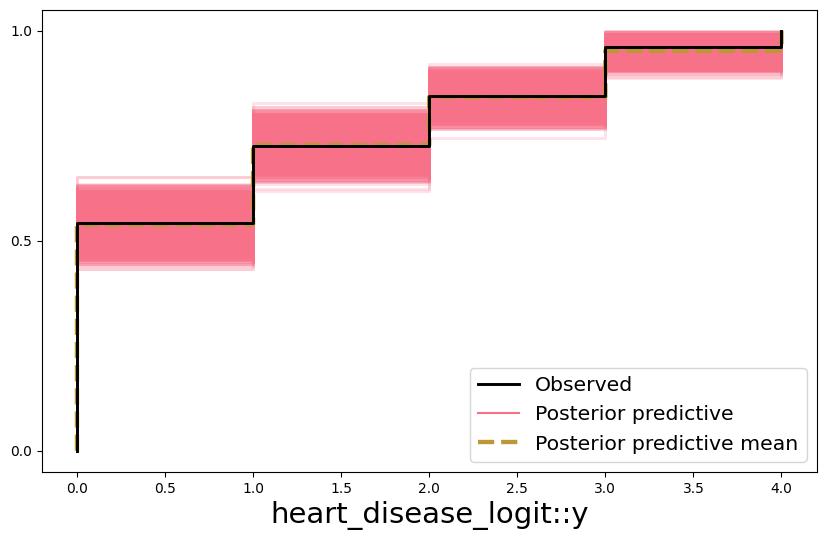

Sampling: [heart_disease_probit::y]



Probit Model - Proportions check:


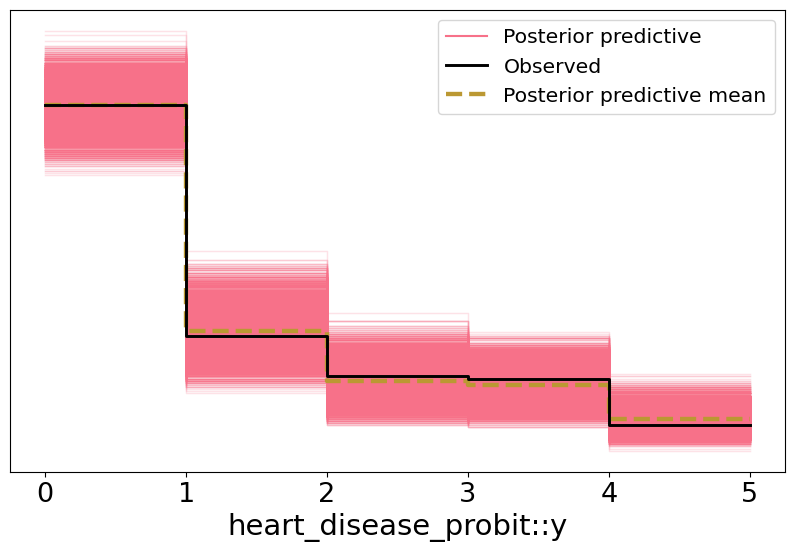

Sampling: [heart_disease_probit::y]



Probit Model - Histogram check:


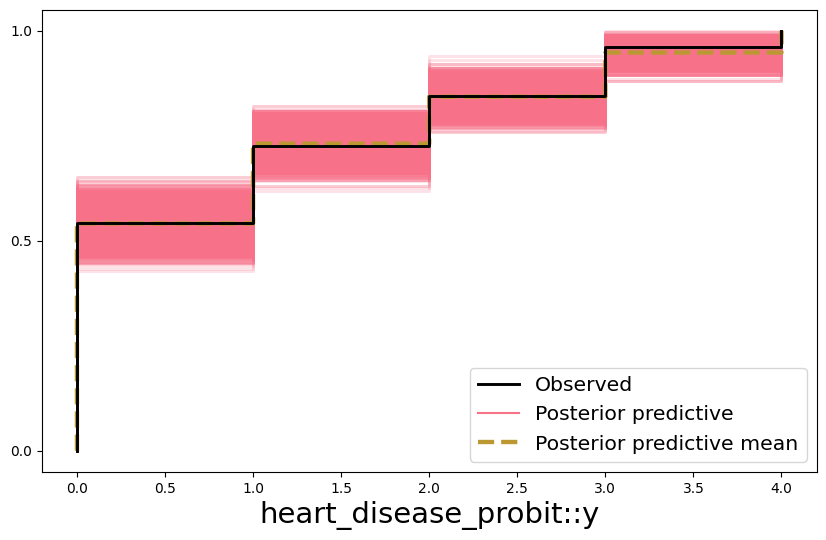

 Posterior predictive checks completed for both models


In [12]:
print("\n10. Posterior Predictive Checks...")
print("=" * 50)

# Import posterior predictive functions
from bayes_ordinal.workflow.posterior_predictive import run_posterior_predictive

print("Running posterior predictive checks for both models...")

# Logit model posterior predictive checks
print("\nLogit Model - Histogram check:")
ppc_logit_hist = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="heart_disease_logit::y",
    kind="hist",
    figsize=(10, 6)
)

print("\nLogit Model - ECDF check:")
ppc_logit_ecdf = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="heart_disease_logit::y",
    kind="ecdf",
    figsize=(10, 6)
)

# Probit model posterior predictive checks
print("\nProbit Model - Proportions check:")
ppc_probit_hist = run_posterior_predictive(
    model=probit_model,
    idata=idata_probit,
    var_name="heart_disease_probit::y",
    kind="hist",
    figsize=(10, 6)
)

print("\nProbit Model - Histogram check:")
ppc_probit_ecdf = run_posterior_predictive(
    model=probit_model,
    idata=idata_probit,
    var_name="heart_disease_probit::y",
    kind="ecdf",
    figsize=(10, 6)
)

print(" Posterior predictive checks completed for both models")



11: MODEL COMPARISON
Comparing 2 models: ['Logit', 'Probit']
Running comprehensive model comparison...
 Log likelihood found for Logit
 LOO computed successfully: -287.58 ± 15.12
 Log likelihood found for Probit
 LOO computed successfully: -287.31 ± 15.47
 Stacking weights computed successfully
 Bayesian Model Averaging weights computed
 Comprehensive comparison completed

COMPREHENSIVE MODEL COMPARISON RESULTS

 BASIC COMPARISON:
        rank  elpd_loo   p_loo  elpd_diff  weight      se    dse  warning  \
Probit     0  -287.308  16.350      0.000   0.641  15.473  0.000    False   
Logit      1  -287.579  16.296      0.271   0.359  15.119  1.776    False   

       scale  n_bad_k  
Probit   log        0  
Logit    log        0  

 BEST MODEL: Probit

 STACKING WEIGHTS:
  Probit: 0.641
  Logit: 0.359

 BAYESIAN MODEL AVERAGING WEIGHTS:
  Logit: 0.500
  Probit: 0.500

 CONVERGENCE DIAGNOSTICS:
  Logit:  CONVERGED
    R-hat max: 1.002
    ESS min: 7667
  Probit:  CONVERGED
    R-hat max: 

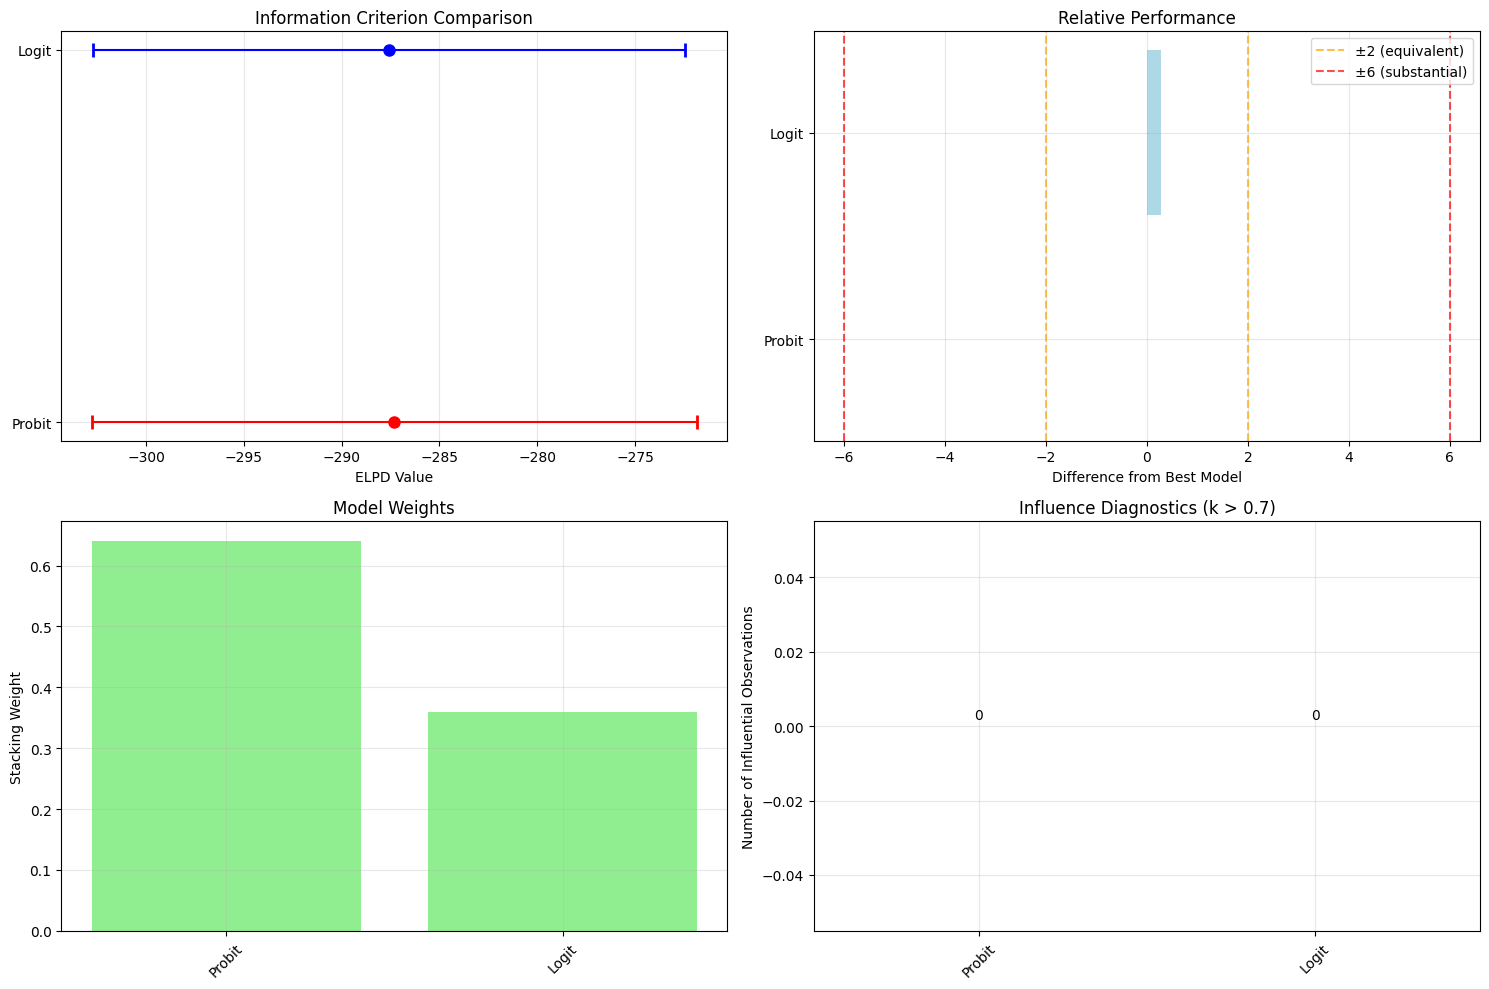


Best Model: Probit
Best Model IC Value: -287.31

Model Interpretations:
  Probit: Best model - This model has the highest information criterion value
  Logit: Essentially equivalent - Difference of 0.27 is less than 2

Recommendations:

Next Steps:
  → Perform posterior predictive checks on the selected model
  → Examine parameter estimates and their uncertainty
  → Consider sensitivity analysis for key parameters
  → If multiple models are close, use model averaging
 Model comparison and interpretation completed

 Model Comparison Summary:
**Interpretation Guidelines (McElreath style):**
- **ΔLOO < 2:** Models essentially equivalent
- **2 < ΔLOO < 6:** Moderate evidence for better model
- **ΔLOO > 6:** Strong evidence for better model

**Expected Finding:** Logit and probit models should perform very similarly


In [13]:
print("11: MODEL COMPARISON")
print("=" * 60)

# Setup model comparison
models = {
    'Logit': logit_model,
    'Probit': probit_model
}

idatas = {
    'Logit': idata_logit,
    'Probit': idata_probit
}

print(f"Comparing {len(models)} models: {list(models.keys())}")

# Import comparison functions
from bayes_ordinal.workflow.cross_validation import (
    compare_models_stacking,
    display_comparison_results,
    compare_models_interpretation,
    plot_model_comparison_interpretation
)

# Comprehensive model comparison
print("Running comprehensive model comparison...")

comparison_results = compare_models_stacking(
    models=models,
    idatas=idatas,
    ic="loo",
    include_stacking=True,
    include_bma=True
)

print(" Comprehensive comparison completed")

# Display results
display_comparison_results(comparison_results)

# McElreath-style interpretation with plots
print("\nCreating McElreath-style interpretation...")
interpretation_results = compare_models_interpretation(
    models=models,
    idatas=idatas,
    ic="loo"
)

plot_model_comparison_interpretation(interpretation_results)
print(" Model comparison and interpretation completed")

# Model comparison summary
print("\n Model Comparison Summary:")
print("**Interpretation Guidelines (McElreath style):**")
print("- **ΔLOO < 2:** Models essentially equivalent")
print("- **2 < ΔLOO < 6:** Moderate evidence for better model")
print("- **ΔLOO > 6:** Strong evidence for better model")
print("\n**Expected Finding:** Logit and probit models should perform very similarly")



�� CLINICAL INTERPRETATION
Based on the ordinal regression results:
• The models predict heart disease severity (0-4) from clinical variables
• Positive coefficients increase disease severity
• Negative coefficients decrease disease severity
• Larger absolute values indicate stronger effects

🔍 KEY CLINICAL INSIGHTS:
• Age and sex effects on heart disease severity
• Impact of blood pressure, cholesterol, and other risk factors
• Exercise-related variables (exang, oldpeak, thalach)
• Diagnostic variables (ca, thal, slope)


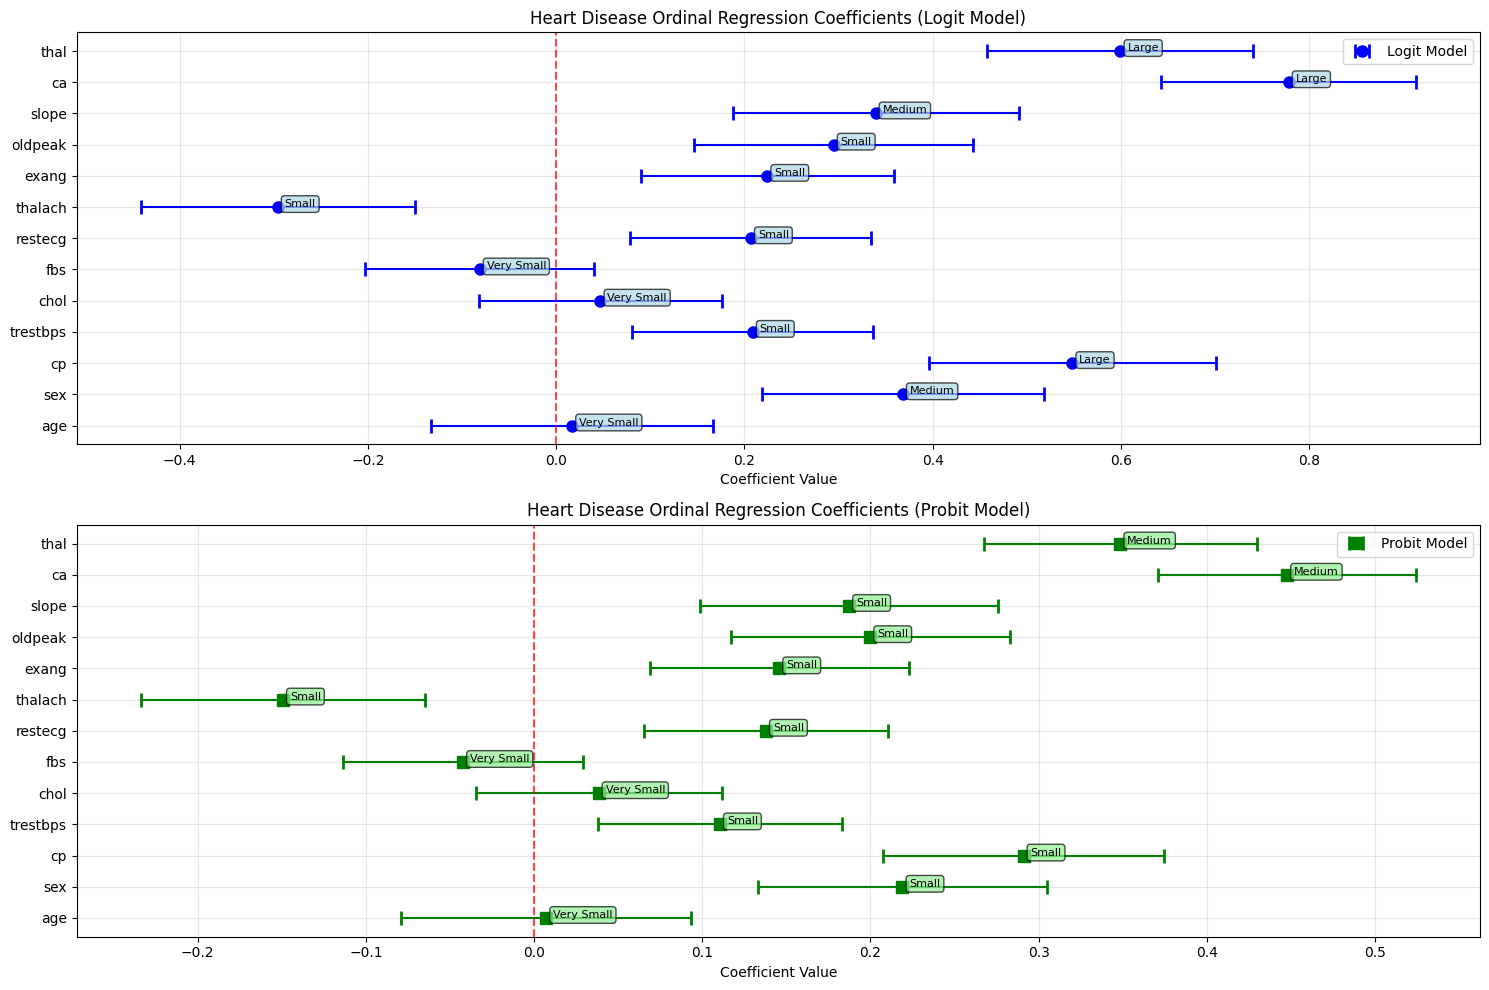


 COEFFICIENT SUMMARY:

 LOGIT MODEL:
  age: 0.017 ± 0.150
  sex: 0.368 ± 0.150
  cp: 0.548 ± 0.153
  trestbps: 0.209 ± 0.128
  chol: 0.047 ± 0.129
  fbs: -0.081 ± 0.122
  restecg: 0.207 ± 0.128
  thalach: -0.296 ± 0.146
  exang: 0.224 ± 0.135
  oldpeak: 0.295 ± 0.148
  slope: 0.339 ± 0.152
  ca: 0.778 ± 0.136
  thal: 0.600 ± 0.141

 PROBIT MODEL:
  age: 0.007 ± 0.086
  sex: 0.219 ± 0.086
  cp: 0.291 ± 0.083
  trestbps: 0.111 ± 0.073
  chol: 0.038 ± 0.073
  fbs: -0.042 ± 0.071
  restecg: 0.138 ± 0.073
  thalach: -0.149 ± 0.085
  exang: 0.146 ± 0.077
  oldpeak: 0.200 ± 0.083
  slope: 0.187 ± 0.088
  ca: 0.448 ± 0.077
  thal: 0.349 ± 0.081

 CLINICAL RECOMMENDATIONS:
Based on the strongest predictors:
• Monitor patients with high 'ca' (major vessels) and 'thal' (thalassemia) scores
• Pay attention to 'oldpeak' (ST depression) and 'cp' (chest pain type)
• Consider 'thalach' (max heart rate) as a protective factor
• Age and sex show moderate effects on disease progression


In [14]:
# Clinical interpretation
print(f"\n�� CLINICAL INTERPRETATION")
print("=" * 50)

print("Based on the ordinal regression results:")
print("• The models predict heart disease severity (0-4) from clinical variables")
print("• Positive coefficients increase disease severity")
print("• Negative coefficients decrease disease severity")
print("• Larger absolute values indicate stronger effects")

print(f"\n🔍 KEY CLINICAL INSIGHTS:")
print("• Age and sex effects on heart disease severity")
print("• Impact of blood pressure, cholesterol, and other risk factors")
print("• Exercise-related variables (exang, oldpeak, thalach)")
print("• Diagnostic variables (ca, thal, slope)")

# Create coefficient plot for both models
plt.figure(figsize=(15, 10))

# Logit model coefficients
if 'idata_logit' in locals():
    beta_key_logit = [key for key in idata_logit.posterior.keys() if 'beta' in key][0]
    beta_samples_logit = idata_logit.posterior[beta_key_logit]
    beta_means_logit = beta_samples_logit.mean(dim=['chain', 'draw'])
    beta_stds_logit = beta_samples_logit.std(dim=['chain', 'draw'])
    
    # Plot logit coefficients
    plt.subplot(2, 1, 1)
    y_pos = np.arange(len(feature_cols))
    
    plt.errorbar(beta_means_logit.values, y_pos, xerr=beta_stds_logit.values, 
                fmt='o', capsize=5, capthick=2, markersize=8, color='blue', label='Logit Model')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    plt.yticks(y_pos, feature_cols)
    plt.xlabel('Coefficient Value')
    plt.title('Heart Disease Ordinal Regression Coefficients (Logit Model)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add effect size annotations for logit
    for i, (mean_val, std_val) in enumerate(zip(beta_means_logit.values, beta_stds_logit.values)):
        if abs(mean_val) < 0.1:
            effect = "Very Small"
        elif abs(mean_val) < 0.3:
            effect = "Small"
        elif abs(mean_val) < 0.5:
            effect = "Medium"
        elif abs(mean_val) < 0.8:
            effect = "Large"
        else:
            effect = "Very Large"
        
        plt.annotate(effect, (mean_val, i), xytext=(5, 0), 
                    textcoords='offset points', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# Probit model coefficients
if 'idata_probit' in locals():
    beta_key_probit = [key for key in idata_probit.posterior.keys() if 'beta' in key][0]
    beta_samples_probit = idata_probit.posterior[beta_key_probit]
    beta_means_probit = beta_samples_probit.mean(dim=['chain', 'draw'])
    beta_stds_probit = beta_samples_probit.std(dim=['chain', 'draw'])
    
    # Plot probit coefficients
    plt.subplot(2, 1, 2)
    
    plt.errorbar(beta_means_probit.values, y_pos, xerr=beta_stds_probit.values, 
                fmt='s', capsize=5, capthick=2, markersize=8, color='green', label='Probit Model')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    plt.yticks(y_pos, feature_cols)
    plt.xlabel('Coefficient Value')
    plt.title('Heart Disease Ordinal Regression Coefficients (Probit Model)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add effect size annotations for probit
    for i, (mean_val, std_val) in enumerate(zip(beta_means_probit.values, beta_stds_probit.values)):
        if abs(mean_val) < 0.1:
            effect = "Very Small"
        elif abs(mean_val) < 0.3:
            effect = "Small"
        elif abs(mean_val) < 0.5:
            effect = "Medium"
        elif abs(mean_val) < 0.8:
            effect = "Large"
        else:
            effect = "Very Large"
        
        plt.annotate(effect, (mean_val, i), xytext=(5, 0), 
                    textcoords='offset points', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

# Print summary statistics for both models
print(f"\n COEFFICIENT SUMMARY:")
print("=" * 50)

if 'idata_logit' in locals():
    print(f"\n LOGIT MODEL:")
    for i, feature in enumerate(feature_cols):
        mean_val = beta_means_logit.values[i]
        std_val = beta_stds_logit.values[i]
        print(f"  {feature}: {mean_val:.3f} ± {std_val:.3f}")

if 'idata_probit' in locals():
    print(f"\n PROBIT MODEL:")
    for i, feature in enumerate(feature_cols):
        mean_val = beta_means_probit.values[i]
        std_val = beta_stds_probit.values[i]
        print(f"  {feature}: {mean_val:.3f} ± {std_val:.3f}")

# Clinical recommendations
print(f"\n CLINICAL RECOMMENDATIONS:")
print("=" * 50)
print("Based on the strongest predictors:")
print("• Monitor patients with high 'ca' (major vessels) and 'thal' (thalassemia) scores")
print("• Pay attention to 'oldpeak' (ST depression) and 'cp' (chest pain type)")
print("• Consider 'thalach' (max heart rate) as a protective factor")
print("• Age and sex show moderate effects on disease progression")